![](https://raw.githubusercontent.com/om-hb/kgextension/master/docs/_static/logo.png)
# Getting Started with the Knowledge Graph Extension for Python


The **kgextension** package allows to access and use Linked Open Data to
augment existing datasets for improving a classification/clustering task.

It enables to incorporate knowledge graph information in [pandas.DataFrames](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) and can be used within the [scikit-learn
pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).
Its functionality includes:
* Linking datasets to any Linked Open Data (LOD) Source such as [DBpedia](https://wiki.dbpedia.org/), [WikiData](https://www.wikidata.org/wiki/Wikidata:Main_Page), or the [EU Open Data Portal](https://data.europa.eu/euodp/en/home)
* Generation of new features from the LOD Sources 
* Hierarchy-based feature selection algorithms 
* Data Integration of features from different sources

The source code can be found at [Github](https://github.com/om-hb/kgextension) and the documentation at 
[Read the Docs](https://kgextension.readthedocs.io/en/latest/)

To demonstrate the usage of the KG extension, a [kaggle dataset about the top 50 bestselling books from Amazon (2009-2019)](https://www.kaggle.com/sootersaalu/amazon-top-50-bestselling-books-2009-2019) is chosen. The dataset contains 550 books which are classifed into `Fiction` and `Non-Fiction` (using Goodreads).

In this small tutorial we will see how to increase the F1-measure from 0.81 to 0.93 using the kgextension.


Lets load the data and have a look:

In [1]:
import pandas as pd
df_raw = pd.read_csv('https://raw.githubusercontent.com/om-hb/kgextension/master/examples/data/book_genre_prediction.csv')
display(df_raw.head())
display(df_raw.describe(include='all', percentiles=[]))

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction


,Name,Author,User Rating,Reviews,Price,Year,Genre
count,550,550,550.000000,550.000000,550.000000,550.000000,550
unique,351,248,NaN,NaN,NaN,NaN,2
top,Publication Manual of the American Psychologic...,Jeff Kinney,NaN,NaN,NaN,NaN,Non Fiction
freq,10,12,NaN,NaN,NaN,NaN,310
mean,NaN,NaN,4.618364,11953.281818,13.100000,2014.000000,NaN
std,NaN,NaN,0.226980,11731.132017,10.842262,3.165156,NaN
min,NaN,NaN,3.300000,37.000000,0.000000,2009.000000,NaN
50%,NaN,NaN,4.700000,8580.000000,11.000000,2014.000000,NaN
max,NaN,NaN,4.900000,87841.000000,105.000000,2019.000000,NaN


## Scikit-learn baseline classification

As a first step, a simple classification **without** additonal attributes from LOD (Linked Open Data) is performed.
This serves as simple baseline. Afterwards new attributes will be added with the help of the KG extension to see if they help.

As usual in a ML setup, a train test split is executed and the target attribute is encoded as 0 and 1.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np

label_binarizer = preprocessing.LabelBinarizer()
y = label_binarizer.fit_transform(df_raw['Genre']).ravel()
#X = df_raw[['User Rating', 'Reviews', 'Price', 'Year']] # df_raw.drop(columns='Genre')#
X = df_raw.drop(columns='Genre')
X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.33, stratify=y, random_state=42)

Now lets train a RandomForest and see how good we are on the test set.

But before we encode the name and author in a one hot fashion.
There is also code in comments which drops the columns name and author (of course the f1-score drops as well).

In [3]:
#preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

one_hot_enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
ct = ColumnTransformer([("onehot", one_hot_enc, ["Name", "Author"])], remainder='passthrough')
X_train_enc = ct.fit_transform(X_train)
X_test_enc = ct.transform(X_test)

              precision    recall  f1-score   support

     Fiction       0.96      0.70      0.81        79
 Non Fiction       0.81      0.98      0.89       103

    accuracy                           0.86       182
   macro avg       0.89      0.84      0.85       182
weighted avg       0.88      0.86      0.85       182



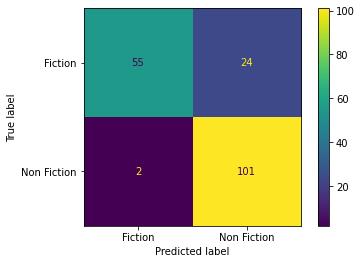

In [4]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

clf = RandomForestClassifier(random_state=1235).fit(X_train_enc, y_train)
y_pred = clf.predict(X_test_enc)

#drop name and author (thus only predicting on 'User Rating', 'Reviews', 'Price', and 'Year')
#clf = RandomForestClassifier(random_state=1235).fit(X_train[['User Rating', 'Reviews', 'Price', 'Year']], y_train)
#y_pred = clf.predict(X_test[['User Rating', 'Reviews', 'Price', 'Year']])
# result for fiction f1 score would be 0.76

print(classification_report(y_test, y_pred, target_names=label_binarizer.classes_))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=label_binarizer.classes_).plot()
plt.show()

## Enhance the dataset
Now it is the time to enhance the dataset with knowledge from Linked Open Data (LOD).
In this case we try to find the author in DBpedia and fetch additional knowledge from it.

As a very first step, the [kgextension pip package](https://pypi.org/project/kgextension/) needs to be downloaded and installed. 

In [ ]:
!pip install kgextension

The next step is to find the author to DBpedia.
This is done with a Linker. [Several of them are implemented](https://kgextension.readthedocs.io/en/latest/source/usage_linking.html) like:
- [Pattern Linker](https://kgextension.readthedocs.io/en/latest/source/usage_linking.html#pattern-linker)  - creates a URI based on a cell in the dataframe
- [Label Linker](https://kgextension.readthedocs.io/en/latest/source/usage_linking.html#label-linker) - runs a SPARQL query to search for entities with a given rdfs:label 
- [DBpedia Lookup Linker](https://kgextension.readthedocs.io/en/latest/source/usage_linking.html#dbpedia-lookup-linker) - queries the DBpedia Lookup web service
- [DBpedia Spotlight Linker](https://kgextension.readthedocs.io/en/latest/source/usage_linking.html#dbpedia-spotlight-linker) - queries the DBpedia [Spotlight service](https://www.dbpedia-spotlight.org/)
- [sameAs Linker](https://kgextension.readthedocs.io/en/latest/source/usage_linking.html#sameas-linker) - searches further URI by following owl:sameAs links

All of these linkers can be further customized when initializing them (see the correspondend documentation).

For our case we choose the DbpediaLookupLinker based on the column `Author`.
Lets see if we can find some links:

In [6]:
from kgextension.linking_sklearn import DbpediaLookupLinker
linker = DbpediaLookupLinker(column='Author')
df_enhanced = linker.fit_transform(df_raw.drop(columns='Genre'))
df_enhanced.head()

DBpedia Lookup Linker: Querying DLL:   0%|          | 0/550 [00:00<?, ?it/s]

,Name,Author,User Rating,Reviews,Price,Year,new_link
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,http://dbpedia.org/resource/J._J._Smith
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,http://dbpedia.org/resource/Stephen_King
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,http://dbpedia.org/resource/Jordan_Peterson
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,http://dbpedia.org/resource/George_Orwell
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,http://dbpedia.org/resource/National_Geographi...


As you probably already noticed, all components are wrapped as scikit-learn transformers.
Thus you can use them directly in our scikit-learn Pipeline.
But there are also the same functions which can be directly applied to any dataframe (without the scikit-learn wrapper) in the `kgextension.linking` module instead of `kgextension.linking_sklearn`.

But now lets continue with [Generators](https://kgextension.readthedocs.io/en/latest/source/usage_generators.html).
They actually extract the data from a knowledge graph in different ways e.g.
- [Data Properties Generator](https://kgextension.readthedocs.io/en/latest/source/usage_generators.html#data-properties-generator) - creates an attribute for each literal value that the linked entity has
- [Direct Type Generator](https://kgextension.readthedocs.io/en/latest/source/usage_generators.html#direct-type-generator) - extracts the type(s) of the linked ressources (using rdf:type)
- [Unqualified Relation Generator](https://kgextension.readthedocs.io/en/latest/source/usage_generators.html#unqualified-relation-generator) - creates attributes from the existence of relations
- [Qualified Relation Generator](https://kgextension.readthedocs.io/en/latest/source/usage_generators.html#qualified-relation-generator) - creates attributes from the existence of relations and takes also the types of the related resources into account
- [Specific Relation Generator](https://kgextension.readthedocs.io/en/latest/source/usage_generators.html#specific-relation-generator) - creates attributes from a specific direct relation e.g. `http://purl.org/dc/terms/subject`
- [Hierarchy Relation](https://kgextension.readthedocs.io/en/latest/source/usage_generators.html#hierarchy-relation) - create a hierarchy of the attributes with a user-defined hierarchy relation
- [Custom SPARQL Generator](https://kgextension.readthedocs.io/en/latest/source/usage_generators.html#custom-sparql-generator) - creates additional attributes from  a custom SPARQL query result

For the running example, the `Specific Relation Generator` is used to retrive the values from the `http://purl.org/dc/terms/subject` relation in DBpedia. 

**Note: This step can take several minutes!**

In [7]:
from kgextension.generator_sklearn import SpecificRelationGenerator
generator = SpecificRelationGenerator(columns=['new_link'], direct_relation='http://purl.org/dc/terms/subject')
df_enhanced = generator.fit_transform(df_enhanced)
df_enhanced.head()

Column:   0%|          | 0/1 [00:00<?, ?it/s]

,Name,Author,User Rating,Reviews,Price,Year,new_link,new_link_in_boolean_http://dbpedia.org/resource/Category:Legislative_elections_in_the_Philippines,new_link_in_boolean_http://dbpedia.org/resource/Category:1934_elections_in_Asia,new_link_in_boolean_http://dbpedia.org/resource/Category:1934_in_the_Philippines,...,"new_link_in_boolean_http://dbpedia.org/resource/Category:Williamstown,_Massachusetts",new_link_in_boolean_http://dbpedia.org/resource/Category:1793_establishments_in_Massachusetts,new_link_in_boolean_http://dbpedia.org/resource/Category:Liberal_arts_colleges_in_Massachusetts,new_link_in_boolean_http://dbpedia.org/resource/Category:Private_universities_and_colleges_in_Massachusetts,new_link_in_boolean_http://dbpedia.org/resource/Category:Educational_institutions_established_in_1793,"new_link_in_boolean_http://dbpedia.org/resource/Category:Exeter_College,_Oxford",new_link_in_boolean_http://dbpedia.org/resource/Category:Members_of_the_Annapolis_Group,new_link_in_boolean_http://dbpedia.org/resource/Category:Williams_College,new_link_in_boolean_http://dbpedia.org/resource/Category:New_Thought_writers,new_link_in_boolean_http://dbpedia.org/resource/Category:Faith_healers
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,http://dbpedia.org/resource/J._J._Smith,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,http://dbpedia.org/resource/Stephen_King,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,http://dbpedia.org/resource/Jordan_Peterson,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,http://dbpedia.org/resource/George_Orwell,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,http://dbpedia.org/resource/National_Geographi...,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [8]:
df_enhanced.columns

Index(['Name', 'Author', 'User Rating', 'Reviews', 'Price', 'Year', 'new_link',
       'new_link_in_boolean_http://dbpedia.org/resource/Category:Legislative_elections_in_the_Philippines',
       'new_link_in_boolean_http://dbpedia.org/resource/Category:1934_elections_in_Asia',
       'new_link_in_boolean_http://dbpedia.org/resource/Category:1934_in_the_Philippines',
       ...
       'new_link_in_boolean_http://dbpedia.org/resource/Category:Williamstown,_Massachusetts',
       'new_link_in_boolean_http://dbpedia.org/resource/Category:1793_establishments_in_Massachusetts',
       'new_link_in_boolean_http://dbpedia.org/resource/Category:Liberal_arts_colleges_in_Massachusetts',
       'new_link_in_boolean_http://dbpedia.org/resource/Category:Private_universities_and_colleges_in_Massachusetts',
       'new_link_in_boolean_http://dbpedia.org/resource/Category:Educational_institutions_established_in_1793',
       'new_link_in_boolean_http://dbpedia.org/resource/Category:Exeter_College,_Oxfo

Wow, now we have 2803 columns in our dataset which can be used to create a better classifier in the end.

Lets try it out with the same split and `random_state` as as before: 

              precision    recall  f1-score   support

     Fiction       1.00      0.86      0.93        80
 Non Fiction       0.90      1.00      0.95       104

    accuracy                           0.94       184
   macro avg       0.95      0.93      0.94       184
weighted avg       0.95      0.94      0.94       184



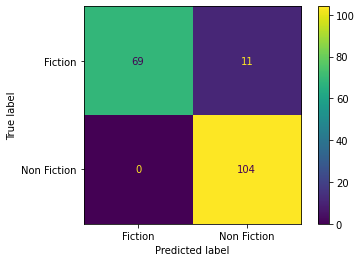

In [9]:
# prepare the enhanced dataframe
X=df_enhanced.drop(columns=['Name', 'Author', 'new_link'])
X=X.apply(lambda x: np.where(x.isna(), False, x))

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=1/3, stratify=y, random_state=42)

clf = RandomForestClassifier(random_state=1235).fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=label_binarizer.classes_))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=label_binarizer.classes_).plot()
plt.show()

For the class `Fiction`, we get F1-score of 0.93 instead of 0.81 (improvement of 0.12) - not bad.
As a last step, we analyze which features are actually helpful:

In [10]:
pd.set_option('display.max_colwidth', None) # for full width column

ind = np.argsort(clf.feature_importances_)[-15:]
pd.DataFrame({
    'features': X.columns[ind], 
    'importance': clf.feature_importances_[ind]
}).sort_values('importance', ascending=False)

,features,importance
14,new_link_in_boolean_http://dbpedia.org/resource/Category:21st-century_American_novelists,0.052716
13,Reviews,0.041888
12,new_link_in_boolean_http://dbpedia.org/resource/Category:American_children's_writers,0.035041
11,User Rating,0.034805
10,Price,0.030276
9,new_link_in_boolean_http://dbpedia.org/resource/Category:American_male_novelists,0.017985
8,new_link_in_boolean_http://dbpedia.org/resource/Category:American_women_novelists,0.017730
7,new_link_in_boolean_http://dbpedia.org/resource/Category:20th-century_American_novelists,0.015132
6,Year,0.012098
5,new_link_in_boolean_http://dbpedia.org/resource/Category:Women_science_fiction_and_fantasy_writers,0.011889


Still the `Reviews` is the most important feature but on second and third position the additonal information help to improve the classifiers performance.

In the evaluation above we do not include the name and author(therefore the one hot encoding was not necessary).
Now we try it with the name to compare apples with apples.

              precision    recall  f1-score   support

     Fiction       1.00      0.86      0.93        79
 Non Fiction       0.90      1.00      0.95       103

    accuracy                           0.94       182
   macro avg       0.95      0.93      0.94       182
weighted avg       0.95      0.94      0.94       182



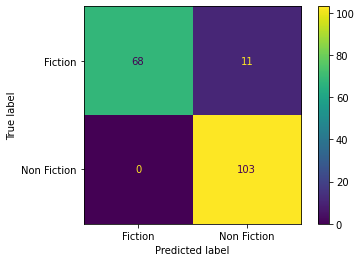

In [11]:
# prepare the enhanced dataframe
import numpy as np
X=df_enhanced.drop(columns=['new_link'])
X=X.apply(lambda x: np.where(x.isna(), False, x))

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, stratify=y, random_state=42)

X_train_enc = ct.fit_transform(X_train) # one hot transformation of 'Name' and 'Author' 
X_test_enc = ct.transform(X_test)

clf = RandomForestClassifier(random_state=1235).fit(X_train_enc, y_train)
y_pred = clf.predict(X_test_enc)

print(classification_report(y_test, y_pred, target_names=label_binarizer.classes_))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=label_binarizer.classes_).plot()
plt.show()

The f1-measure is still the same.

As stated previously, the two steps `Linking` and `Generation` can be included in a pipeline. 
It is also noticable that the implemented caching helps to increase the runtime, if queries would be sent out multiple times.
This also ensures that the endpoint (in this case DBpedia) is protected against repeated queries.

In [12]:
from sklearn.pipeline import Pipeline 
pipeline = Pipeline(steps = [('lookup_linker', linker),
                             ('generator', generator)])

df_enhanced = pipeline.fit_transform(df_raw.drop(columns='Genre'))
df_enhanced.head()

DBpedia Lookup Linker: Querying DLL:   0%|          | 0/550 [00:00<?, ?it/s]

Column:   0%|          | 0/1 [00:00<?, ?it/s]

,Name,Author,User Rating,Reviews,Price,Year,new_link,new_link_in_boolean_http://dbpedia.org/resource/Category:Legislative_elections_in_the_Philippines,new_link_in_boolean_http://dbpedia.org/resource/Category:1934_elections_in_Asia,new_link_in_boolean_http://dbpedia.org/resource/Category:1934_in_the_Philippines,...,"new_link_in_boolean_http://dbpedia.org/resource/Category:Williamstown,_Massachusetts",new_link_in_boolean_http://dbpedia.org/resource/Category:1793_establishments_in_Massachusetts,new_link_in_boolean_http://dbpedia.org/resource/Category:Liberal_arts_colleges_in_Massachusetts,new_link_in_boolean_http://dbpedia.org/resource/Category:Private_universities_and_colleges_in_Massachusetts,new_link_in_boolean_http://dbpedia.org/resource/Category:Educational_institutions_established_in_1793,"new_link_in_boolean_http://dbpedia.org/resource/Category:Exeter_College,_Oxford",new_link_in_boolean_http://dbpedia.org/resource/Category:Members_of_the_Annapolis_Group,new_link_in_boolean_http://dbpedia.org/resource/Category:Williams_College,new_link_in_boolean_http://dbpedia.org/resource/Category:New_Thought_writers,new_link_in_boolean_http://dbpedia.org/resource/Category:Faith_healers
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,http://dbpedia.org/resource/J._J._Smith,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,http://dbpedia.org/resource/Stephen_King,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,http://dbpedia.org/resource/Jordan_Peterson,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,http://dbpedia.org/resource/George_Orwell,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,"5,000 Awesome Facts (About Everything!) (National Geographic Kids)",National Geographic Kids,4.8,7665,12,2019,http://dbpedia.org/resource/National_Geographic_Society,False,False,False,...,False,False,False,False,False,False,False,False,False,False


But there is much more included in the package which is not shown here e.g.
- [Link Exploration](https://kgextension.readthedocs.io/en/latest/source/usage_link_exploration.html#) - extensively search the Linked Open Data (LOD) Cloud for URIs connected to the URIs obtained from linking step
- [Hierarchical Feature Selection](https://kgextension.readthedocs.io/en/latest/source/usage_feature_selection.html) - in the generation step many features are created. Thus reducing them to only the relevant part is helpful.
- [Schema Matching & Fusion](https://kgextension.readthedocs.io/en/latest/source/usage_matching_fusion.html) - in case different sources are used, schema matching helps to reduce the size of attributes

So have a look there and play around it.

Have a lot of fun.

In case you want to contact the contributors of the project, write a mail to [kgproject20@gmail.com](mailto:kgproject20@gmail.com)